# Image Captioning with Attention

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import image

import itertools
import random

tf.random.set_seed(1)

Loading the Data. The data consist of pictures and labels of linear functions

In [2]:
import cv2
import os

def load_images_from_folder(folder, n_imgs=-1):
    images = []
    image_nums = []
    for filename in os.listdir(folder)[:n_imgs]:
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            image_nums.append(filename.strip('.png'))
    return images, image_nums

folder="../../../Math Equations/linear_fcns/images"

In [3]:
images, fnames = load_images_from_folder(folder,18000)

In [4]:
labels = pd.read_csv('../../../Math Equations/linear_fcns/data.csv')

In [5]:
labels['img_number'] = labels['filename'].apply(lambda x: x.split('/')[-1].strip('.png'))

In [6]:
labels.head()

,latex,filename,img_number
0,0a+1=2,linear_fcns/images/0.png,0
1,0b+1=2,linear_fcns/images/1.png,1
2,0c+1=2,linear_fcns/images/2.png,2
3,0d+1=2,linear_fcns/images/3.png,3
4,0e+1=2,linear_fcns/images/4.png,4


In [7]:
label_array = labels[labels['img_number'].isin(fnames)]['latex'].values

For the labels we need to add start and end tokens so the model can recognize what to write.

In [8]:
label_array = [f'\t{la}\n' for la in label_array]

Let's reshape the images so we can plot them.

In [9]:
images_for_split = images
images = np.array(images)
images = 255 - images
images = tf.image.rgb_to_grayscale(images)
images = images.numpy()
images.shape

(18000, 72, 360, 1)

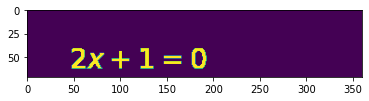

In [10]:
plt.imshow(images[0])

Now we can process them and prepare them for inceptionv3 which is transfer learning

In [11]:
img_train, img_test, img_train_name, img_test_name = train_test_split(images, label_array, test_size=.2)

In [12]:
img_val = img_test

In [24]:
img_mini = tf.image.resize_with_pad(img_train, 225, 225)
img_test= tf.image.resize_with_pad(img_test, 125, 125)

In [25]:
#img_mini = tf.image.resize(img_train, (150, 150))
#img_test= tf.image.resize(img_test, (150, 150))

Now we can load the features of the inceptionv3 model as seen below.

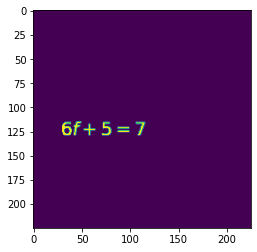

In [26]:
plt.imshow(img_mini[0])

In [25]:
image_model = tf.keras.models.load_model('../Learning CNNs/saved_model/my_model2')

new_input = image_model.input
hidden_layer = image_model.layers[-7].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [16]:
# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices((img_mini, img_train_name)).batch(1000)#(img_mini, label_array)).batch(1)
c = 1

for img, label in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
  
    p = f'../Batch Features My CNN/batch_features{c}'
    c = c+1 
     #path_of_feature = p.numpy().decode("utf-8")
    np.save(p, batch_features)

In [31]:
# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices((img_test, img_test_name)).batch(1000)#(img_mini, label_array)).batch(1)
c = 1

for img, label in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
  
    p = f'../Batch Features My CNN Test/batch_features{c}'
    c = c+1 
     #path_of_feature = p.numpy().decode("utf-8")
    np.save(p, batch_features)

In [26]:
img_load = np.load('../Batch Features My CNN/batch_features1.npy')
for i in range(2,61):
    img_add = np.load(f'../Batch Features My CNN/batch_features{i}.npy')
    img_load = np.concatenate((img_load, img_add))

FileNotFoundError: [Errno 2] No such file or directory: '../Batch Features My CNN/batch_features16.npy'

In [34]:
img_val_load = np.load('../Batch Features My CNN Test/batch_features1.npy')
for i in range(2,61):
    img_add = np.load(f'../Batch Features My CNN Test/batch_features{i}.npy')
    img_val_load = np.concatenate((img_val_load, img_add))

FileNotFoundError: [Errno 2] No such file or directory: '../Batch Features My CNN Test/batch_features5.npy'

In [27]:
img_load.shape

(14400, 1024, 15)

In [35]:
img_val_load.shape

(3600, 1024, 15)

### Tokenizing the labels

Now we can pad the labels to make sure they are all the same length.

In [36]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [57]:
# Choose the top 5000 words from the vocabulary
top_k = 41
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters=' ',
                                                  char_level=True)
tokenizer.fit_on_texts(img_train_name)#label_array)
train_seqs = tokenizer.texts_to_sequences(img_train_name)

# Padding
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(img_train_name)
test_seqs = tokenizer.texts_to_sequences(img_test_name)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
cap_vector_val = tf.keras.preprocessing.sequence.pad_sequences(test_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [38]:
tokenizer.get_config()

{'num_words': 41,
 'filters': ' ',
 'lower': True,
 'split': ' ',
 'char_level': True,
 'oov_token': '<unk>',
 'document_count': 14400,
 'word_counts': '{"\\t": 14400, "2": 4299, "r": 555, "+": 14400, "9": 4341, "=": 14400, "1": 4288, "\\n": 14400, "l": 537, "8": 4262, "7": 4305, "0": 4303, "a": 563, "4": 4277, "y": 543, "6": 4390, "j": 563, "g": 548, "s": 549, "m": 572, "d": 537, "t": 568, "x": 536, "3": 4355, "i": 567, "u": 552, "e": 564, "5": 4380, "z": 554, "h": 561, "f": 554, "w": 546, "p": 550, "v": 584, "b": 550, "n": 550, "c": 551, "k": 538, "q": 557, "o": 551}',
 'word_docs': '{"r": 555, "\\t": 14400, "9": 4341, "1": 4288, "+": 14400, "=": 14400, "2": 4299, "\\n": 14400, "l": 537, "8": 4262, "7": 4305, "0": 4303, "a": 563, "6": 4390, "4": 4277, "y": 543, "j": 563, "g": 548, "s": 549, "m": 572, "d": 537, "t": 568, "x": 536, "3": 4355, "i": 567, "u": 552, "5": 4380, "e": 564, "z": 554, "h": 561, "f": 554, "w": 546, "p": 550, "v": 584, "b": 550, "n": 550, "c": 551, "k": 538, "q":

In [39]:
max_length

8

In [40]:
print(f'{label_array[0]} -> {train_seqs[0]}')

	0b+1=2
 -> [2, 12, 25, 3, 9, 4, 13, 5]


In [41]:
import json

char_to_int_map = tokenizer.get_config()['word_index']
char_to_int_map = json.loads(char_to_int_map)
[char_to_int_map[c] for c in img_train_name[0]]

[2, 12, 25, 3, 9, 4, 13, 5]

In [55]:
# Feel free to change these parameters according to your system's configuration
embedding_dim = 45
units = 32
vocab_size = top_k + 1
num_steps = len(img_train) // 1
val_num_steps = len(img_test) // 1
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 1024

## Model

Below we are defining the attention, the encoder and the decoder. The encoder is just a fully connected layer from the features already extracted.

In [74]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [75]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        #print(f'This is x: {x}')
        x = tf.nn.relu(x)
        #print(f'This is x: {x}')
        return x

In [76]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)
        #print('decoder attention complete')

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        #print('decoder embedding complete')
        #print(f'x.shape = {x.shape}')
        #print(f'context_vector.shape = {context_vector.shape}')

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        #print('decoder embedding + context vector complete')

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        #print('decoder gru complete')

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)
        #print('decoder fc1 complete')

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))
        #print('decoder reshape complete')

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)
        #print('decoder fc2 complete')

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [77]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [78]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [79]:
checkpoint_path = "./checkpoints/train_my_cnn"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [80]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
      start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
      # restoring the latest checkpoint in checkpoint_path
      ckpt.restore(ckpt_manager.latest_checkpoint)

In [81]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []
val_loss_plot=[]

In [82]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

          # initializing the hidden state for each batch
          # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])
    #print(f'hidden complete: {hidden}')

    # Create a vector of all \t indices to indicate the start of prediction
    dec_input = tf.expand_dims([tokenizer.word_index['\t']] * target.shape[0], 1)
    #print(f'dec_input complete: {dec_input}')

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        #print('encoder complete')
        #print(f'features.shape = {features.shape}')

        # iterate through timesteps to predict the i'th character
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            #print('decoder complete')

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [83]:
@tf.function
def val_step(img_tensor, target, teacher_forcing=True):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['\t']] * target.shape[0], 1)

    features = encoder(img_tensor)
    
    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions)

        dec_input = tf.expand_dims(target[:, i], 1)

    avg_loss = (loss / int(target.shape[1]))
    return loss, avg_loss

def cal_val_loss(val_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(val_dataset):
        batch_loss, t_loss = val_step(img_tensor, target)
    
        total_loss += t_loss
    #print ('Valid Loss {:.6f}'.format(total_loss/val_num_steps))
    return (total_loss/val_num_steps)

In [84]:
image_dataset_encoded = tf.data.Dataset.from_tensor_slices((img_load, cap_vector)).batch(1000)
val_dataset = tf.data.Dataset.from_tensor_slices((img_val_load, cap_vector_val)).batch(1000)

In [105]:
import time
EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(image_dataset_encoded):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        
        val_loss = cal_val_loss(val_dataset)

        if batch % 1 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, batch_loss / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    val_loss_plot.append(val_loss)

    if epoch % 5 == 0:
        ckpt_manager.save() 
    print(num_steps)
    print ('Epoch {} Loss {:.6f} Val Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps, val_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.2763
Epoch 1 Batch 1 Loss 1.2756
Epoch 1 Batch 2 Loss 1.2760
Epoch 1 Batch 3 Loss 1.2761
Epoch 1 Batch 4 Loss 1.2758
Epoch 1 Batch 5 Loss 1.2766
Epoch 1 Batch 6 Loss 1.2771
Epoch 1 Batch 7 Loss 1.2762
Epoch 1 Batch 8 Loss 1.2762
Epoch 1 Batch 9 Loss 1.2758
Epoch 1 Batch 10 Loss 1.2758
Epoch 1 Batch 11 Loss 1.2761
Epoch 1 Batch 12 Loss 1.2760
Epoch 1 Batch 13 Loss 1.2764
Epoch 1 Batch 14 Loss 1.2755
14400
Epoch 1 Loss 0.001329 Val Loss 0.001418
Time taken for 1 epoch 142.85155725479126 sec

Epoch 2 Batch 0 Loss 1.2756
Epoch 2 Batch 1 Loss 1.2750
Epoch 2 Batch 2 Loss 1.2753
Epoch 2 Batch 3 Loss 1.2754
Epoch 2 Batch 4 Loss 1.2751
Epoch 2 Batch 5 Loss 1.2760
Epoch 2 Batch 6 Loss 1.2765
Epoch 2 Batch 7 Loss 1.2756
Epoch 2 Batch 8 Loss 1.2755
Epoch 2 Batch 9 Loss 1.2752
Epoch 2 Batch 10 Loss 1.2752
Epoch 2 Batch 11 Loss 1.2755
Epoch 2 Batch 12 Loss 1.2754
Epoch 2 Batch 13 Loss 1.2761
Epoch 2 Batch 14 Loss 1.2750
14400
Epoch 2 Loss 0.001329 Val Loss 0.001417
Time taken 

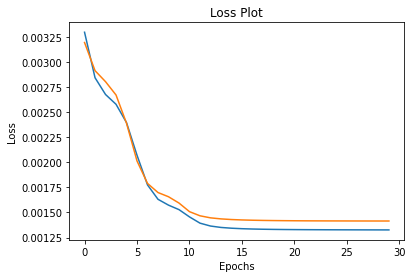

In [106]:
plt.plot(loss_plot)
plt.plot(val_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# Evaluate

In [98]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(image, 0)
    #print(temp_input)
    img_tensor_val = image_features_extract_model(temp_input)
    #print(img_tensor_val)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    #print(img_tensor_val)
    
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['\t']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        #print(attention_weights.shape)
        attention_plot[i] = tf.reshape(attention_weights, (-1, ))

        predicted_id = tf.random.categorical(predictions, 1)[0][0]
        predicted_id = int(predicted_id)
        result.append(tokenizer.index_word[predicted_id])
        #print(tokenizer.index_word[predicted_id])
        ind = np.argpartition(predictions, -4)[0][-4:]
        #print(f'These are the top choices {"".join(tokenizer.index_word[c] for c in ind)}')
        #print(f'This are the probabilities {predictions.numpy()[0,ind]}')

        if tokenizer.index_word[predicted_id] == '\n':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [99]:
def plot_attention(image, result, attention_plot):
    
    #-1 goes to zero
    temp_image = np.array(image)

    fig = plt.figure(figsize=(10, 10))
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show();

Run attention_plot to see what it looks like

Prediction Caption: 6 v + 7 = 8 



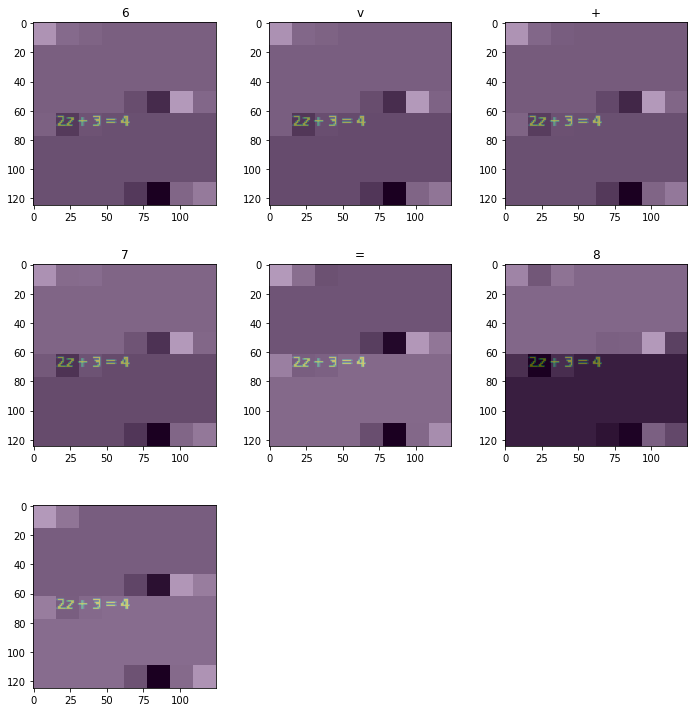

In [107]:
result, attention_plot = evaluate(img_test[0])
print ('Prediction Caption:', ' '.join(result))
plot_attention(img_test[0], result, attention_plot)
# opening the image

Prediction Caption: 7 p + 9 = 3 



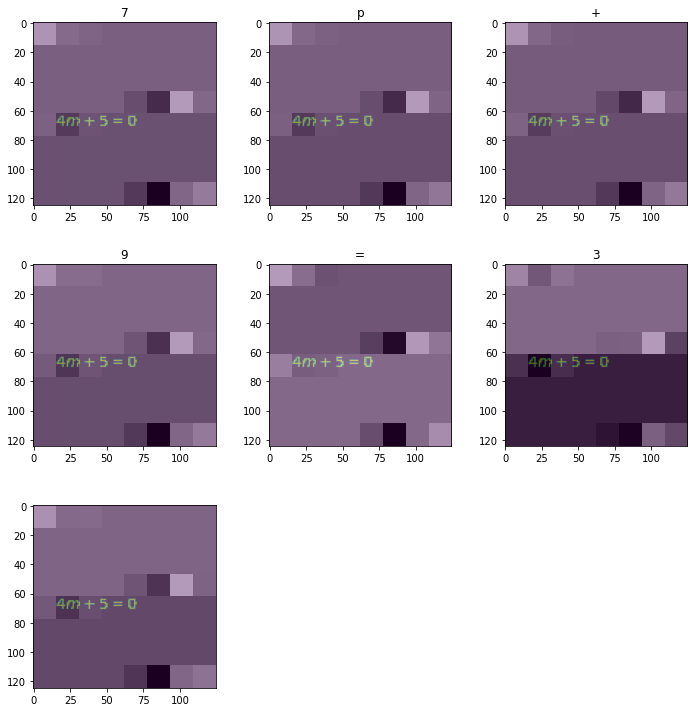

In [109]:
result, attention_plot = evaluate(img_test[9])
print ('Prediction Caption:', ' '.join(result))
plot_attention(img_test[9], result, attention_plot)
# opening the image

Prediction Caption: 7 h + 5 = 4 



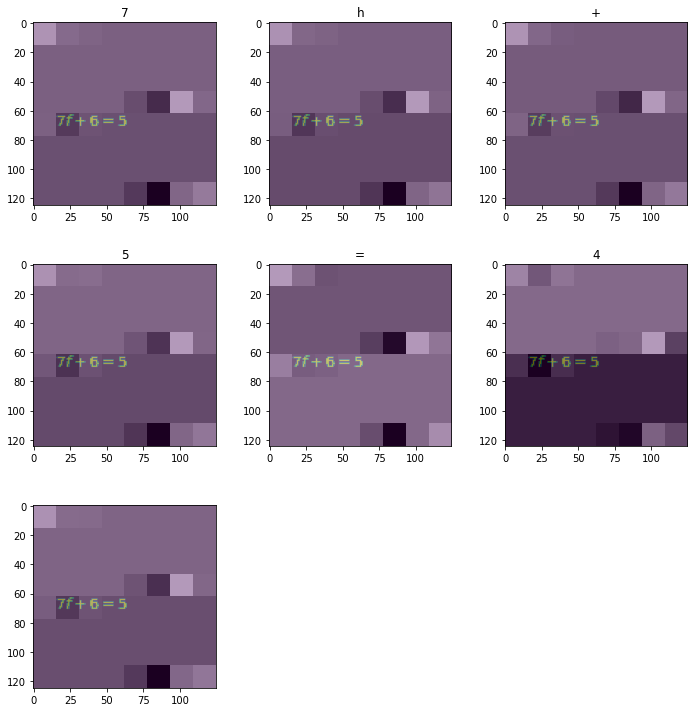

In [110]:
result, attention_plot = evaluate(img_test[5])
print ('Prediction Caption:', ' '.join(result))
plot_attention(img_test[5], result, attention_plot)
# opening the image

In [103]:
def check_results(images, labels, num_imgs=10):
    for i in range(0, num_imgs):
        result, attention_plot = evaluate(images[i])
        print('Prediction Caption:', ' '.join(result))
        print(f'Actual Caption: ', labels[i])
        #plot_attention(images[i], result, attention_plot)

In [112]:
check_results(img_test, img_test_name)

Prediction Caption: 8 q + 9 = 6 

Actual Caption:  	8k+2=9

Prediction Caption: 8 j + 1 = 1 

Actual Caption:  	0o+1=6

Prediction Caption: 3 z + 8 = 7 

Actual Caption:  	1s+2=7

Prediction Caption: 9 b + 6 = 4 

Actual Caption:  	7u+4=1

Prediction Caption: 4 p + 2 = 6 

Actual Caption:  	4b+9=3

Prediction Caption: 1 k + 2 = 8 

Actual Caption:  	5j+1=8

Prediction Caption: 1 u + 2 = 1 

Actual Caption:  	5j+0=1

Prediction Caption: 4 <unk> + 6 = 8 

Actual Caption:  	6s+5=9

Prediction Caption: 2 i + 8 = 7 

Actual Caption:  	3d+4=1

Prediction Caption: 4 = 9 = 1 = 1 

Actual Caption:  	7s+0=3

